In [2]:

%load_ext autoreload
%autoreload 2
from pathlib import Path
from pixelator import read_pna as read
from pixelator.pna.plot import molecule_rank_plot

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
import pandas as pd
from pixelator.common.statistics import clr_transformation, dsb_normalize
import scanpy as sc
from pixelator.mpx.plot import density_scatter_plot
import scanpy.external as sce
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm
from pixelator.common.statistics import clr_transformation, dsb_normalize

from pixelator.pna.analysis import calculate_differential_proximity
from rich import print

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import sys
sys.path.append('/home/projects/nyosef/zvise/PixelGen/PixelGen')
from utils import ridgeplot_multilayer, ridgeplot_spatial, plot_tau_yanai, build_spatial_obsms, build_spatial_obsms_with_scaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA LOAD

In [3]:
DATA_DIR = Path("/home/projects/nyosef/zvise/PxlgnProject/Data")
files = [f for f in DATA_DIR.rglob('*.pxl') if f.is_file()]
data = read(files)

adata=data.adata()
spatial=data.proximity().to_df()

def get_condition(sample):
    if '_4hrs' in sample:
        return '4_hrs'
    elif '_24hrs' in sample:
        return '24_hrs'
    else:
        return 'control'


adata.obs['run'] = adata.obs['sample'].apply(lambda x: 'run_1' if 'PNA065' in x else ('run_2' if 'PNA066' in x else None))
adata.obs['condition'] = adata.obs['sample'].apply(get_condition)
adata.obs['sample_name']=adata.obs['condition']+'_'+adata.obs['run']

spatial["condition"] = spatial["sample"].apply(get_condition)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
adata.layers['counts']=adata.X.copy()
adata.layers['clr']=adata.obsm['clr']
adata.layers['log1p']=adata.obsm['log1p']
adata.layers["arcsinh"] = np.arcsinh(adata.X / 5)

# 1.B FILTERING

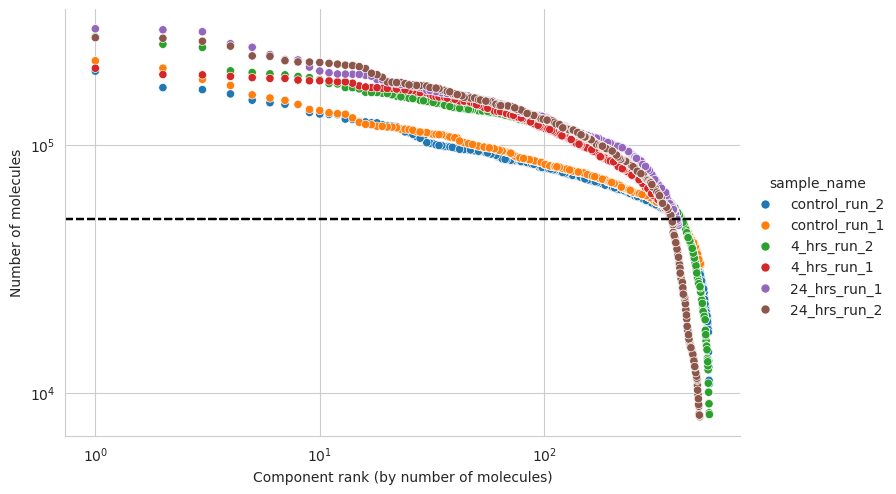

In [5]:
molecule_rank_df = adata.obs[["sample_name", "n_umi"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample_name"])["n_umi"].rank(
    ascending=False, method="first"
)
fig_intersection, ax = molecule_rank_plot(molecule_rank_df, group_by="sample_name")
molecule_thresh = {
    'control_run_1': 50000,
    'control_run_2': 50000,
    '4_hrs_run_1': 50000,
    '4_hrs_run_2': 50000,
    '24_hrs_run_1': 50000,
    '24_hrs_run_2': 50000,
}
for sample, thresh in molecule_thresh.items():
    ax.axhline(thresh, color='black', linestyle='--')

In [6]:
thres=50000
cells_to_keep = adata.obs[adata.obs.n_umi >= thres].index

print ('before filter')
print(adata.obs.index.nunique())

adata=adata[cells_to_keep].copy()
spatial=spatial[spatial.component.isin(cells_to_keep)].copy()

print ('after filter')
print(adata.obs.index.nunique())

before filter

2857

after filter

2338

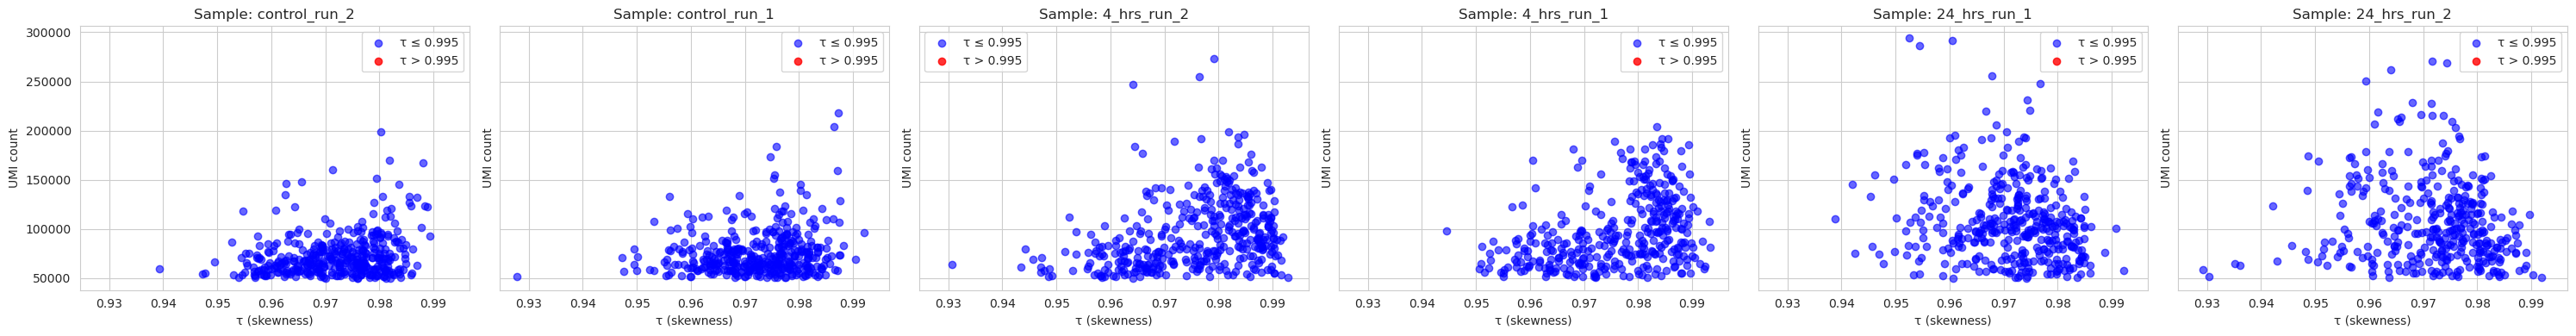

In [7]:
tau_df = plot_tau_yanai(adata)


# 1.C TRANSFORMATIONS

In [8]:
adata

AnnData object with n_obs × n_vars = 2338 × 159
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'n_antibodies', 'reads_in_component', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'run', 'condition', 'sample_name'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear'
    obsm: 'clr', 'log1p'
    layers: 'counts', 'clr', 'log1p', 'arcsinh'

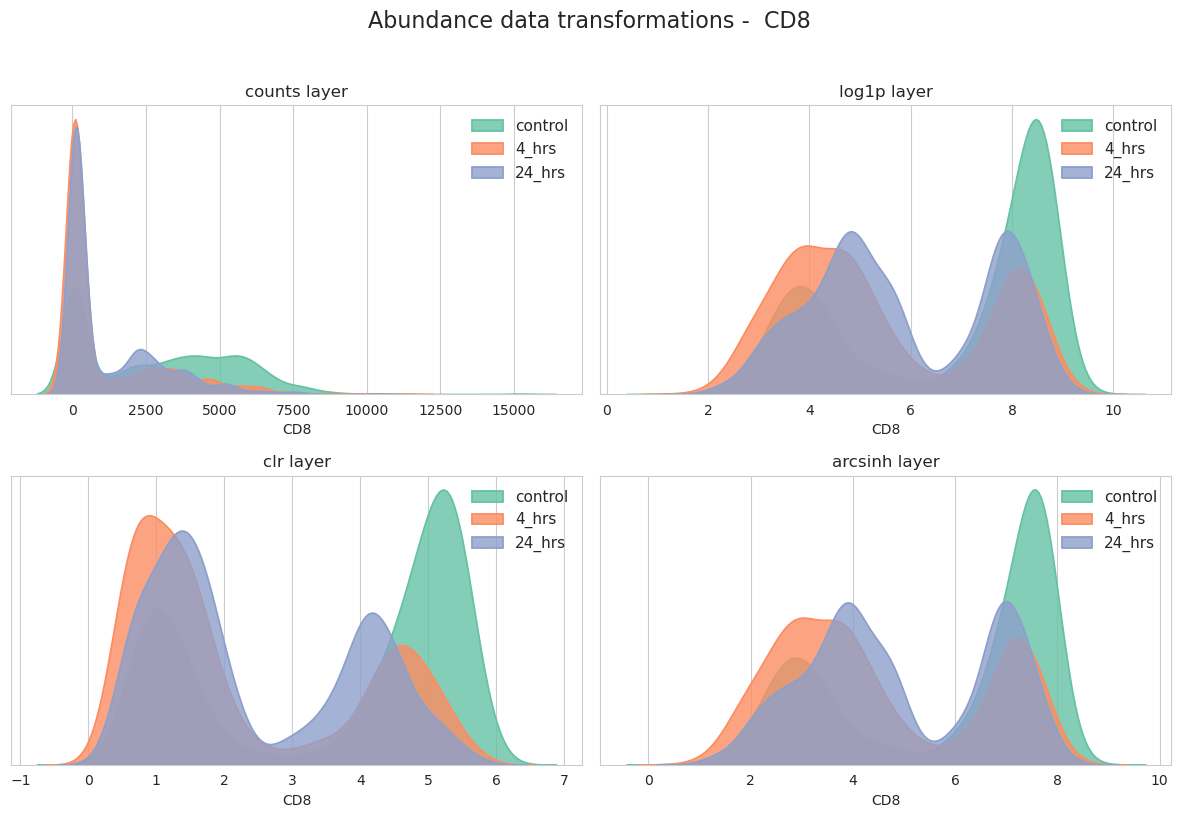

In [9]:
layers = ["counts", "log1p", "clr", "arcsinh"]

ridgeplot_multilayer(
    adata,
    marker="CD8",
    layers=layers,
    condition_col="condition"
)

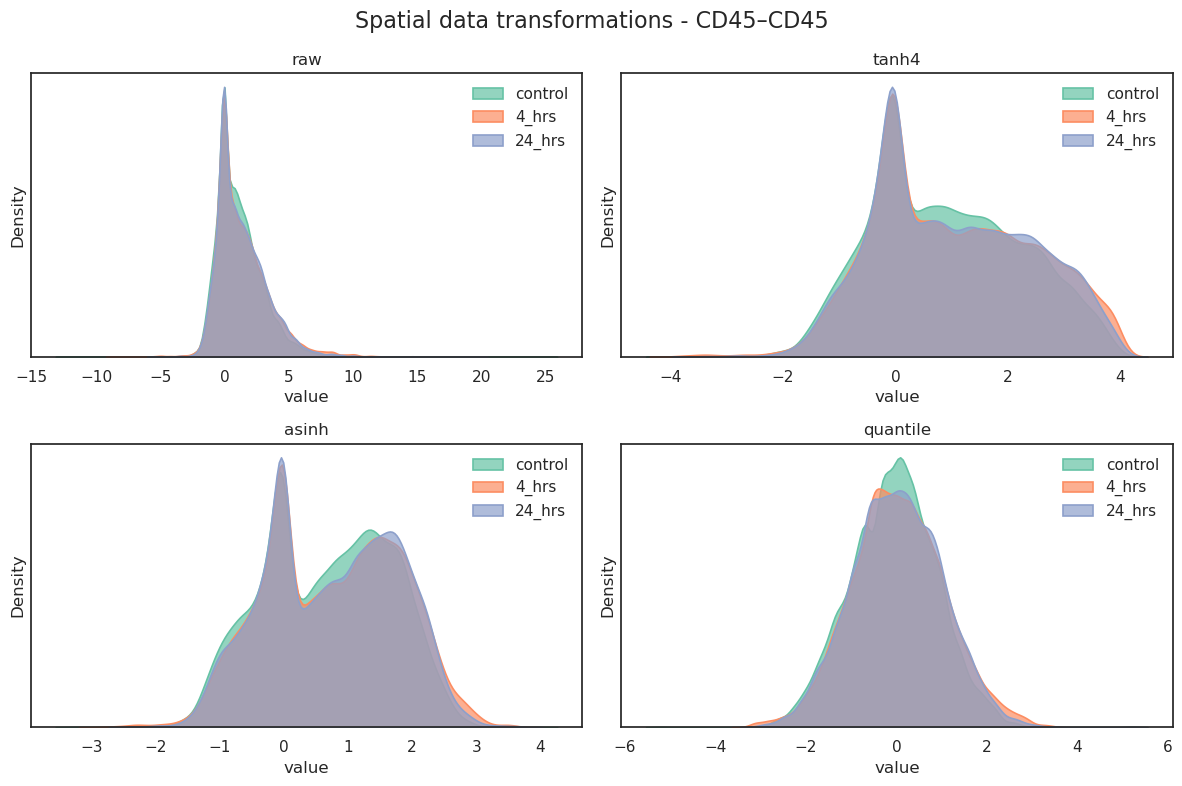

In [10]:
ridgeplot_spatial(
    df=spatial,
    marker1_prefix="cd45",
    marker2_prefix="cd45",
    condition_col="condition"
)

In [11]:
build_spatial_obsms_with_scaler(adata, spatial)


Created obsm keys: spatial_raw spatial_tanh4 spatial_asinh spatial_quantile spatial_asinh_robust
Shape: (2338, 12720)


In [12]:
adata

AnnData object with n_obs × n_vars = 2338 × 159
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'n_antibodies', 'reads_in_component', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'run', 'condition', 'sample_name'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear'
    obsm: 'clr', 'log1p', 'spatial_raw', 'spatial_tanh4', 'spatial_asinh', 'spatial_quantile', 'spatial_asinh_robust'
    layers: 'counts', 'clr', 'log1p', 'arcsinh'

In [13]:
adata.write_h5ad('/home/projects/nyosef/zvise/PxlgnProject/Data/final_adatas/adata_asinh_scaled_for_model.h5ad')